# Dimensionality reduction example

The goal of this script is to illustrate dimensionality reduction of timeseries
data using the singular value decomposition to derive a maximum variance 
representation.

For this, do the following:

    1. Definitions and imports
    2. Create covariance function
    3. Simulate the data
    4. Dimensionality reduction
    5. Plots and illustrations

The following entries may be changed to explore the script:

    * sigma_noise , sigma_signal  : Both together define the signal-to-noise ration in the data
    * cov_type                    : The form of the correlation function. Only the strings 'sq_exp',
                                    'exp', and 'white' are allowed.
    * corr_length_signal          : A quantity describing how slow the correlation between values drops
                                    depending on temporal separation. Increase to generate a smoother signal.
    * cov_type_guess              : The form of the guessed correlation function. Only the strings 'sq_exp',
                                    'exp', and 'white' are allowed.
    * corr_length_signal_guess    : A quantity describing how slow assumedly the correlation between values drops
                                    depending on temporal separation. Increase to generate a smoother signal.                                                                      
    * n_expansion                 : The maximum amount of expansion coefficients for the dimensionality reduction.
                                    The bigger this quantity, the more terms are used to represent the signal.
    * n_show                      : The amount of reconstructions / elements shown in figures
                                                                        
This script is given out as part of the Machine Learning Tutorial during IV2020, Munich. Please consult the slides for some background information regarding motivation and a possible physical setup for this toy example.

Written by Jemil Butt, Zan Gojcic, ETH Zurich.

# 1. Definitions and imports ------------------------------------------------

Define the length $n_{datapoints}$ of the timeseries $x$, the standarddeviation of noise $\sigma_{noise}$ and the correlation length $\rho_{signal}$ of the simulated signal. Different correlation lengths $\rho_{signal}$ lead to different regularity properties of the data that is to be reconstructed in later steps. Different types of correlation structures can be chosen.
 $$\begin{align}\text{'sq_exp'}: k_{signal}(s,t)&=\exp\left[-\left(\frac{s-t}{\rho_{signal}}\right)^2\right] &&\text{leads to smooth signals} \\
 \text{'exp'}: k_{signal}(s,t)&=\exp\left[-\frac{|s-t|}{\rho_{signal}}\right] &&\text{leads to continuous, nondifferentiable signals}\\
   \text{'white'}: k_{signal}(s,t)&=\delta_{st} =\mathbb{1}_{s=t}(s,t) &&\text{leads to uncorrelated signals} \end{align}$$

Example signal 'sq_exp'       $\hspace{5cm}$     Example signal 'exp' $\hspace{5cm}$ Example signal 'white'

![High correlation length -> smooth behavior](https://drive.google.com/uc?id=1tWeF_Btm5L-pMf0sk2ZNipUnNWwUeCiw)

Adjusting $\sigma_{noise}$ leads to different signal to noise ratios. The bigger $\sigma_{noise}$ is the more noisy the data looks like and the harder it is for the algorithm to reconstruct the data due to the unpredictability of the white noise. For reconstructing the data, $n_{expansion}$ basis functions $u_k(\cdot)$ are employed. They are superimposed in the following way.
$$ x_{data}\approx \sum_{k=1}^{n_{expansion}}\alpha_k u_{k}(\cdot)$$ The number n_{expansion} of basis functions to be used is adjustable and the quality of the reconstruction improves with increasing $n_{expansion}$. The basis functions $u_k(\cdot)$ are not known a priori and finding them so as to reconstruct $x_{data}$ with the minimum number of coefficients is part of the problem.

In [1]:

# 1.1 Import numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt


# 1.2 Define the number of observations and the time at which they take place
#       (Time interval is arbitrarily set to [0,1] to avoid scaling issues)
n_datapoints=100
time=np.linspace(0,1,n_datapoints)

#1.3 Parameters for simulationa and estimation

# Parameters for simulation             # The following parameters may be changed to explore the method
sigma_noise=0.0                         # Quantifies the average magnitude of the noise
cov_type='sq_exp'                       # Quantifies the correlation structure of the data
corr_length_signal=0.3                  # A quantity describing how slow the correlation between values drops
                                        # depending on temporal separation.
                                        
# Parameters for dimensionality reduction    
cov_type_guess='sq_exp'                 # A guess for the correlation structure of the data
corr_length_signal_guess=0.3            # A guess for the smoothness of the signal. Is used to construct a 
                                        # covariance matrix whose eigenfunctions reconstruct the signal                                                  
n_expansion=10                          # The amount of eigenfunctions used to reconstruct the measured signal

# Parameters for visualization
n_show=3

print('Packages imported. The parameters for simulation and representation have been defined and are now \
ready for later use.')


Packages imported. The parameters for simulation and representation have been defined and are now ready for later use.


# 2. Create covariance function  ------------------------------------------------

Covariance functions $k(\cdot,\cdot)$ are a compact way of encoding the spatial dependence of the correlation structure. They are used to construct the covariance matrices necessary for inference and prediction by evaluating $k$ via
$$k(\cdot,\cdot):T\times T\ni (s,t)\mapsto k(s,t)\in \mathbb{R}$$
to generate the covariance matrix $K$ with elements $(K)_{ij}=k(t_i,t_j)$. For the simple case of an 1-D interval $T$ in time, $k(\cdot,\cdot)$ is a two-dimensional function specifying the correlation between $t$ and $s$ for all $(s,t)\in T\times T$. Some typical structures are plotted below.

Covariance matrix 'sq_exp'       $\hspace{3cm}$     Covariance matrix 'exp' $\hspace{3cm}$ Covariance matrix 'white'
![alt text](https://drive.google.com/uc?id=1GpVAyEaOwiWonGdTSO5tmmeGTZopClWI)

In [2]:

def Create_covariance_matrix(cov_type,input_vector,correlation_length,dimensions):

    # 2.1 Rename for comfort   
    n=dimensions
    t=input_vector

    # 2.2 Case based evaluation 

    if cov_type == 'white':
        cov_fun=lambda t_1,t_2: np.multiply(1,t_1==t_2)
    elif cov_type == 'sq_exp':
        cov_fun=lambda t_1,t_2: np.exp(-np.power(((t_1-t_2)/correlation_length),2))
    elif cov_type == 'exp':
        cov_fun=lambda t_1,t_2: np.exp(-np.abs(((t_1-t_2)/correlation_length)))
    else:
        print('Wrong type of covariance function specified.')
        
    # 2.3 Assemble matrix and return 

    Cov_mat=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Cov_mat[i,j]=cov_fun(t[i],t[j])
            
    return Cov_mat

print('Defined a function for assembling covariance matrices from correlation functions.')
    

Defined a function for assembling covariance matrices from correlation functions.


# 3. Simulate the data ------------------------------------------------------

Simulate randomly chosen smooth signals by considering them to be drawn from a multivariate Gaussian distribution with dimension $n_{timesteps}$. With e.g. $n_{timesteps}=100$, each throw of the dice produces a vector of length 100 that we interpret as a function mapping dimension indices to function values. We then draw $x_{signal}$ according to
$$ x_{signal}\sim\mathcal{N}(0,K)$$
where $0\in \mathbb{R}^{100}$ and $K\in \mathbb{R}^{100 \times 100}$. $\mathcal{N}$ symbolizes the multivariate Gaussian distribution. Even though each draw is random and the different realizations are independent of each other, there exists significant spatial correlation between neighboring values. This can be exploited not only for interpolation and estimation (as done in the regression example). It also to means that of the $100$ elements few are truly uncorrelated and many redundant - therefore the $100$ elements in $x_{signal}$ can be represented by significantly less numbers. More explanations of the intuition behind the simulation process may be found in the notes associated to the regression example.

In [3]:

# 3.1 Define the covariance matrices of signal an noise for simulation

Cov_mat_signal=Create_covariance_matrix(cov_type,time,corr_length_signal,n_datapoints)
Cov_mat_noise=pow(sigma_noise,2)*Create_covariance_matrix('white',time,0,n_datapoints)

# 3.2 Define a guess for the covariance matrix of the signal
Cov_mat_signal_guess=Create_covariance_matrix(cov_type_guess,time,corr_length_signal_guess,n_datapoints)
        
# 3.3 Do the simulation - first simulate random signal ...
x_true=np.random.multivariate_normal(np.zeros([n_datapoints]),Cov_mat_signal)

# ... then add noise to create the synthetic measurements
x_measured=x_true+np.random.multivariate_normal(np.zeros([n_datapoints]),Cov_mat_noise)

print('Covariance matrices have been constructed. Simulations were carried out by sampling from \
multivariate normal distributions.')


Covariance matrices have been constructed. Simulations were carried out by sampling from multivariate normal distributions.


# 4. Dimensionality reduction -----------------------------------------------

The goal is to find an orthonormal sequence of basis vectors $\{u_j(\cdot)\}_{j=1}^k$ such that reconstruction of the signal $x_{signal}$ via $x_{reconstruct}=\sum_{j=1}^k\langle x_{signal},u_j\rangle u_j$ is possible up to a small residual RMSE with the smallest number $k$ of basis vectors. Since our data is stochastic and the exact form of $x_{signal}$ is unknown beforehand, we need to pose the optimization problem in terms of expected values. The task is to solve
$$ u_1, ... , u_k =\underset{v_1, ... , v_k \text{ orthonormal}}{\operatorname{argmin}} E\left[ \|\sum_{j=1}^k \langle x_{signal},v_j\rangle v_j - x_{signal}\|\right]. $$

Knowledge of the covariance matrix $K$ is sufficient to reconstruct any randomly chosen signal $x_{signal}$ with known correlation structure and in this case a closed form solution can be derived. It is based on the spectral decomposition of $K$.

$$\text{Spectral theorem } \hspace{2cm} K= U \Lambda U^T \hspace{2cm}\text{where } \Lambda \text{ diagonal and } U \text{ unitary}$$


Denoting the elements of $\Lambda$ by $\lambda_i$ one finds the energy of the expected reconstruction error to be
$$ \begin{align}
E[\|x_{signal}-x_{reconstruct}\|^2_2]=E\left[\|\sum_{j=k+1}^{n_{timesteps}}\langle x_{signal},u_j\rangle u_j\|^2_2\right]&=\sum_{j=k+1}^{n_{timesteps}}u_jE\left[x_{signal}x_{signal}^T\right]u_j \\
&=\sum_{j=k+1}^{n_{timesteps}} \lambda_j
\end{align}$$

The reconstruction error decreases therefore monotonically with $k$ and the first eigenvector decreases the energy of the residuals $x_{signal} - x_{reconstruct}$ by $\lambda_1$ - the largest amount possible. This means that - on average - no other single function $u(\cdot)$ can be used better to approximate $x_{signal}$ than $u_1(\cdot)$.
When trying to find the best $k$ vectors $v_1 , ... ,v_k$ to reconstruct $x_{signal}$ via $x_{reconstruct}=\sum_{j=1}^k \alpha_j v_j$, the eigenvectors $u_1, ... ,u_k$ minimize $E\left[\|x_{signal}-x_{reconstruct}\|^2_2\right]$ among all possible vectors and are therefore the best choice.

In [4]:

# 4.1 Extract basis elements
u,s,vh=np.linalg.svd(Cov_mat_signal_guess)
basis_elements=u[:,0:n_expansion]

# 4.2 Represent signal in new basis
coeffs=basis_elements.T@x_measured
signal_reconstruct=np.zeros([n_datapoints,n_expansion])
reconstruction_rmse=np.zeros(n_expansion)

for k in range(n_expansion):
    signal_reconstruct[:,k]=basis_elements[:,0:k+1]@coeffs[0:k+1]
    reconstruction_rmse[k]=np.linalg.norm(signal_reconstruct[:,k]-x_measured)/np.sqrt(n_datapoints);

print('Singular value decomposition performed and basis functions extracted. Reconstruction using the \
most efficient n_expansion basis functions.')


Singular value decomposition performed and basis functions extracted. Reconstruction using the most efficient n_expansion basis functions.


# 5. Plots and illustrations ------------------------------------------------

Illustrate the decomposition and reconstruction procedure by first plotting the randomly chosen signal to be processed. The eigenvectors corresponding to the largest eigenvalues of the covariance matrices are plotted in the second figure. They correspond to the basis vectors with the most explanatory power. 

Figure 3 shows the increasingly more faithful reconstructions whose RMSE monotonically decreases with increasing number of basis functions used for reconstruction. For smooth functions with much correlations structure to exploit, $10$ coefficients may be sufficient for an almost perfect reconstruction amounting to a compression of factor $10$. The actual decay of the RMSE with increasing amount of basis elements used for reconstruction is shown in figure 4.

Text(0, 0.5, 'RMSE')

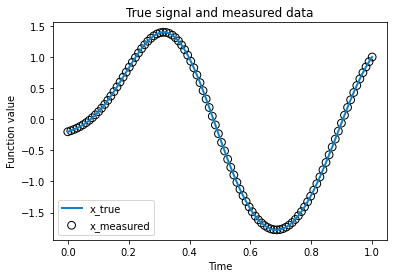

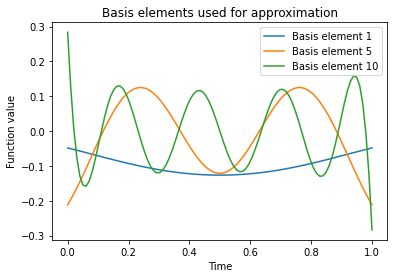

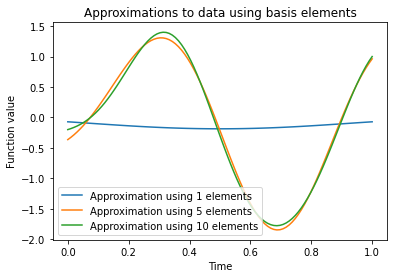

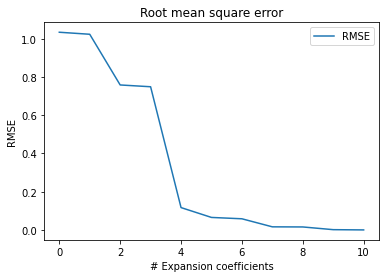

In [5]:

# 5.1 Figure showing the measured data and the true underlying signal
plt.figure(1)
plt.scatter(time,x_measured,s=60, facecolors='none', edgecolors='k')
plt.plot(time,x_true,color='xkcd:cerulean',linewidth=2)
plt.title('True signal and measured data')
plt.legend(['x_true','x_measured'])
plt.xlabel('Time')
plt.ylabel('Function value')

# 5.2 Figure showing the basis elements used to reconstruct the measured signal
plt.figure(3)
index_show=np.round(np.linspace(0,n_expansion-1,n_show)).astype(int)
index_basis=index_show+np.ones(3)
plt.plot(time,basis_elements[:,index_show])
plt.title('Basis elements used for approximation')
plt.legend(['Basis element %d'% index_basis[0],'Basis element %d'% index_basis[1], 'Basis element %d' % index_basis[2]])
plt.xlabel('Time')
plt.ylabel('Function value')

# 5.3 Figure showing the reconstructions of the measured data in terms of an 
# increasing sequence of basis elements
plt.figure(2)
plt.plot(time,signal_reconstruct[:,index_show])
plt.title('Approximations to data using basis elements')
plt.legend(['Approximation using %d elements' % index_basis[0],'Approximation using %d elements' % index_basis[1],\
            'Approximation using %d elements' % index_basis[2]])
plt.xlabel('Time')
plt.ylabel('Function value')

# 5.4 Figure showing the decay of the rmse with increasing amount of basis elements
# used for reconstruction
plt.figure(4)
plt.plot(np.insert(reconstruction_rmse,0,np.linalg.norm(x_measured)/np.sqrt(n_datapoints)))
plt.title('Root mean square error')
plt.legend(['RMSE'])
plt.xlabel('# Expansion coefficients')
plt.ylabel('RMSE')